In [20]:
from dotenv import load_dotenv

from IPython.display import Image, display
import gradio as gr

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# from langchain_community.llms import ChatLlama
# from langchain_community.chat_models import ChatOllama
from langchain_ollama import ChatOllama

from typing import Annotated, TypedDict
import requests
import os

In [21]:
load_dotenv(override=True)

True

In [22]:
from langchain_community.utilities import GoogleSerperAPIWrapper
from langgraph.checkpoint.memory import MemorySaver

serper = GoogleSerperAPIWrapper()
# serper.run("What is the capital of France?")

memory = MemorySaver()

In [23]:
from langchain.agents import Tool

tool_search = Tool(
    name="search",
    description="Useful for when you need more information from an online search",
    func=serper.run
)

In [24]:
# tool_search.invoke("What is the capital of France?")

In [25]:
from typing import Any


def calculate_math(expression: str) -> str:
    """Calculate mathematical expressions safely"""
    try:
        # Remove any potentially dangerous characters and evaluate safely
        allowed_chars: set[str] = set('0123456789+-*/(). ')
        if all(c in allowed_chars for c in expression):
            result = eval(expression)
            return f"ผลลัพธ์: {expression} = {result}"
        else:
            return "ข้อผิดพลาด: นิพจน์ไม่ถูกต้อง ใช้ได้เฉพาะตัวเลขและเครื่องหมาย +, -, *, /, (, ) เท่านั้น"
    except Exception as e:
        return f"ข้อผิดพลาดในการคำนวณ: {str(e)}"

calculate_tool: Any = Tool(
    name="calculator",
    func=calculate_math,
    description="Use this to calculate mathematical expressions. Input should be a valid math expression like '2 + 3 * 4' or '(10 + 5) / 3'"
)

calculate_tool.invoke("1+2")

'ผลลัพธ์: 1+2 = 3'

#### Create Tools

In [26]:
tools = [calculate_tool, tool_search]

#### Step 1: Define the State object

In [27]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

#### Step 2: Start the Graph Builder with this State class

In [28]:
graph_builder = StateGraph(State)

In [29]:
llm = ChatOllama(model="llama3.1")

llm_with_tools = llm.bind_tools(tools)

#### Step 3: Create a Node

In [30]:
def chatbot(state: State) -> State:
    """This function is called when the user sends a message to the chatbot."""

    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

### Step 4: Create Edges

In [31]:
graph_builder.add_conditional_edges("chatbot", tools_condition, {"tools": "tools"})
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

### Step 5: Compli the Graph

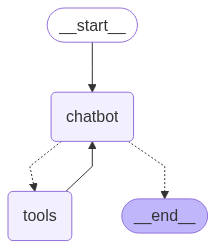

In [32]:
graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

#### This's is? And, let's do this.

In [33]:
config = {"configurable": {"thread_id": "123"}}

def chat(user_input: str, history) -> str:
    """This function is called when the user sends a message to the chatbot."""
    result =graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config)
    print(result)
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


In [34]:
graph.get_state(config)

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '123'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())

In [35]:
list(graph.get_state_history(config))

[]

## OK it's time to add Memory!

### BUT WAIT!

We have this whole Graph maintaining the state and appending to the state.  
**Why isn't this handling memory?**

---

## This is a crucial point for understanding LangGraph

> A super-step can be considered a single iteration over the graph nodes.  
> Nodes that run in parallel are part of the same super-step,  
> while nodes that run sequentially belong to separate super-steps.

- One **"Super-Step"** of the graph represents one invocation of passing messages between agents.
- In idiomatic LangGraph, you call `invoke()` to run your graph for each super-step; for each interaction.
- The reducer handles state updates automatically **within one super-step**, but **not between them**.

That is what **checkpointing** achieves.


In [36]:
from langgraph.checkpoint.memory import MemorySaver

memory: MemorySaver = MemorySaver()


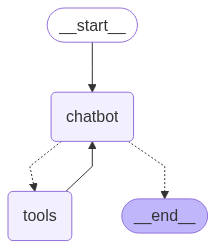

In [ ]:
graph_builder = StateGraph(State)

llm = ChatOllama(model="qwen3")

llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State) -> State:
    """This function is called when the user sends a message to the chatbot."""

    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

graph_builder.add_conditional_edges("chatbot", tools_condition, {"tools": "tools"})
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))


In [38]:
config = {"configurable": {"thread_id": "222"}}

def chat(user_input: str, history) -> str:
    """This function is called when the user sends a message to the chatbot."""
    result =graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config)
    print(result)
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.
